In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from scipy.sparse import csr_matrix

In [ ]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.weights1 = np.random.randn(input_dim, hidden_dim)
        self.bias1 = np.zeros((1, hidden_dim))
        self.weights2 = np.random.randn(hidden_dim, output_dim)
        self.bias2 = np.zeros((1, output_dim))
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1)[:, np.newaxis])
        return exps / np.sum(exps, axis=1)[:, np.newaxis]
    def forward_pass(self, X):
        self.hidden_out = self.sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.output = self.softmax(np.dot(self.hidden_out, self.weights2) + self.bias2)
    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        grad_output = self.output - y
        grad_weights2 = np.dot(self.hidden_out.T, grad_output)
        grad_bias2 = np.sum(grad_output, axis=0).reshape(1, -1)
        grad_hidden = np.dot(grad_output, self.weights2.T) * (self.hidden_out * (1 - self.hidden_out))
        grad_weights1 = np.dot(X.T, grad_hidden)
        grad_bias1 = np.sum(grad_hidden, axis=0).reshape(1, -1)
        self.weights1 -= learning_rate * grad_weights1 / m
        self.bias1 -= learning_rate * grad_bias1 / m
        self.weights2 -= learning_rate * grad_weights2 / m
        self.bias2 -= learning_rate * grad_bias2 / m
    def train(self, X, y, epochs, learning_rate):
        for i in range(epochs):
            self.forward_pass(X)
            self.backward_pass(X, y, learning_rate)
            if i % 100 == 0:
                loss = self.calculate_loss(X, y)
                print(f"Loss after epoch {i}: {loss}")
    def calculate_loss(self, X, y):
        m = X.shape[0]
        cross_entropy_loss = -np.sum(y * np.log(self.output)) / m
        return cross_entropy_loss

In [ ]:
df = pd.read_csv("9 horseRacing.csv")

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['calc_position'] = df['calc_position'].apply(lambda x: 1 if x == 1 else 0)

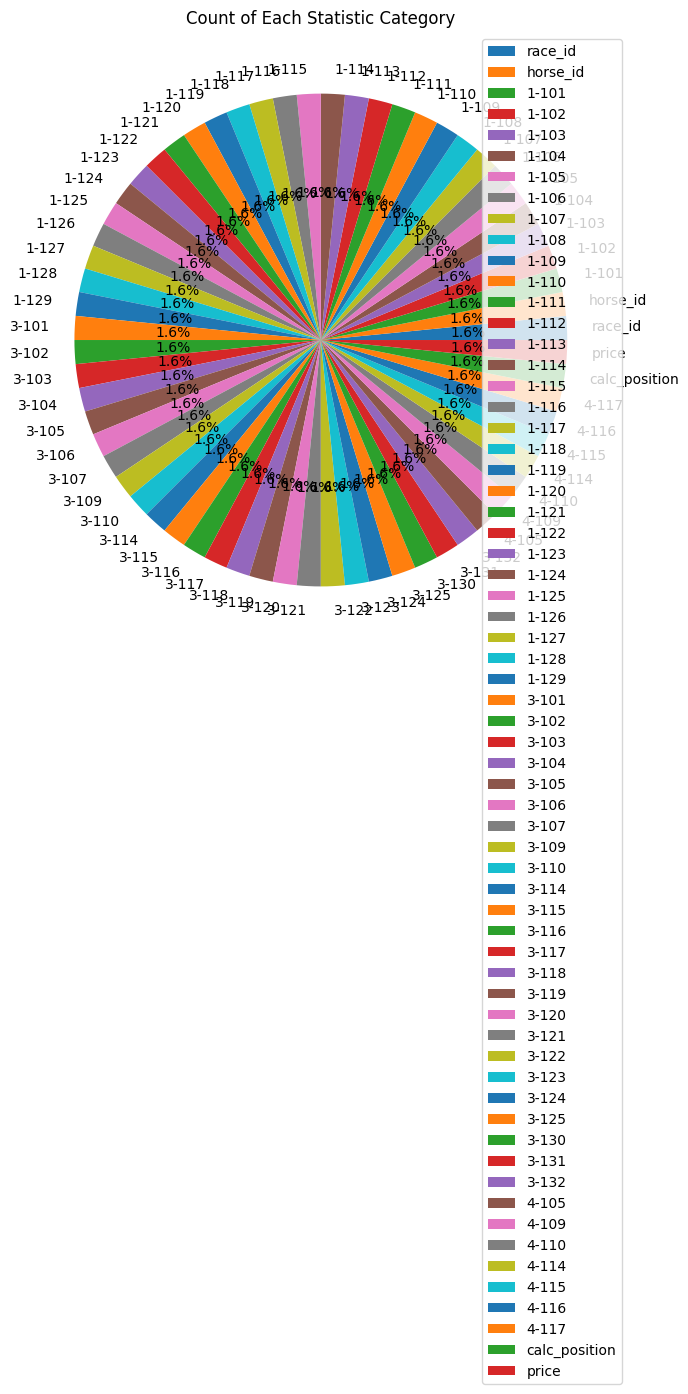

In [ ]:
df.describe().loc['count'].plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%')
plt.title("Count of Each Statistic Category")
plt.ylabel("")
plt.legend(df.describe().columns, loc="upper right")
plt.show()

In [ ]:
X = df.drop(columns=['calc_position', 'price'])
y = df['calc_position']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
encoder = OneHotEncoder(sparse=True)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
input_dim = X_train_scaled.shape[1]
hidden_dim = 32
output_dim = len(encoder.categories_[0])
mlp = MLP(input_dim, hidden_dim, output_dim)

In [ ]:
epochs = 1000
learning_rate = 0.01
mlp.train(X_train_scaled, y_train_encoded.toarray(), epochs, learning_rate)

Loss after epoch 0: 1.7248503216812296
Loss after epoch 100: 0.5944668070260954
Loss after epoch 200: 0.5014721483466127
Loss after epoch 300: 0.48094938758015343
Loss after epoch 400: 0.4706309975622765
Loss after epoch 500: 0.4625122557305996
Loss after epoch 600: 0.4551762441429259
Loss after epoch 700: 0.4483226852851346
Loss after epoch 800: 0.4418692453894449
Loss after epoch 900: 0.43577918299879764


In [ ]:
mlp.forward_pass(X_test_scaled)
y_pred_prob = mlp.output
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_encoded.toarray(), axis=1)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Confusion Matrix:
[[2157  116]
 [ 214   17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2273
           1       0.13      0.07      0.09       231

    accuracy                           0.87      2504
   macro avg       0.52      0.51      0.51      2504
weighted avg       0.84      0.87      0.85      2504



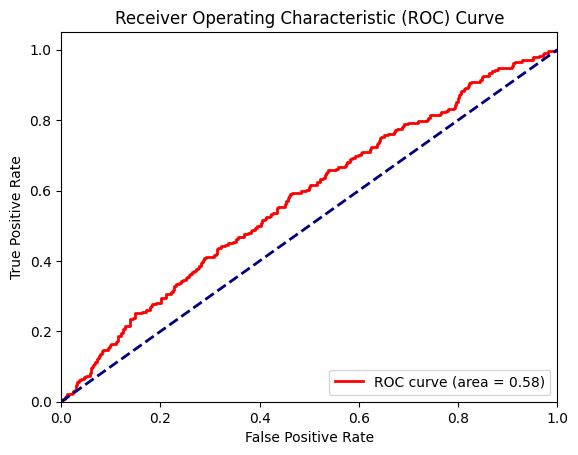

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

THE DATA SET WAS WAY TOO LARGE SO I REDUCED THE BATCH SIZE TO 32 ,ALSO ADJUSTED HIDDEN LAYER DIMENSION ,USED SPARCE MATRICES.